## Task 2
### Classify applicants as either high or low earners

In this task, I attempt to use the other features in the data to determine whether a worker is a high or low earner.

In [1]:
# first to import the relevant packages
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn import preprocessing, pipeline, feature_selection, decomposition
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier as RFC

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

%matplotlib inline
from IPython.display import Image

/home/kilian/virtualenvs/elucd/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/kilian/virtualenvs/elucd/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Further data cleaning after Task 1

The steps I did differently can be seen in the notebooks on geocoding for location in Task 2, and the first attempts at solving Task 2. Here are the main steps

1. Using census data for placenames, I geocoded the work locations to latitude and longitude coordinates. I used DBSCAN clustering to find work locations that belonged to similar regions in the USA and made class variables based on these clusters, shown below.
2. One overlooked field in the initial cleaning was dealt with - the prevailing wage survey source data - and cleaned as previous text data was and sorted into common classes
3. All class variables were dummy encoded into columns consisting of binary values for the most common companies, places, surveys, etc.
4. All non-binary data was standardised to have zero mean and unit variance for approximately normal data - like the salaries - or normalised to lie between 0 and 1 otherwise.
5. prevailing wage data for location 2 was considered to be equal to the location one data in the cases where there was no second location.

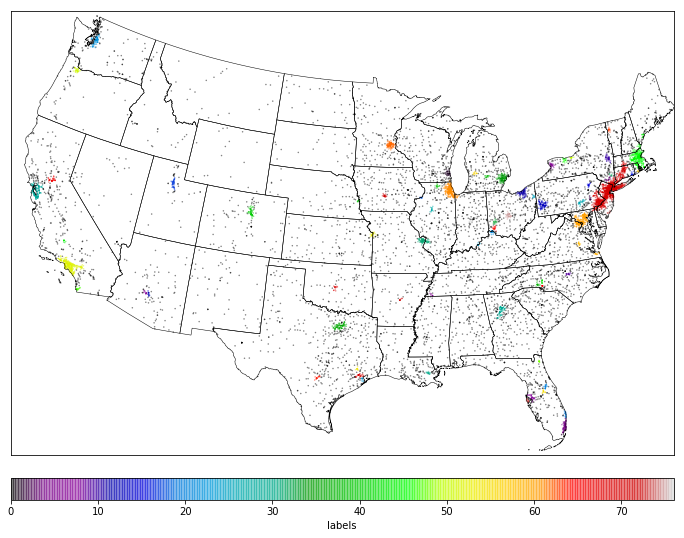

In [4]:
Image(filename='../dat/clustermap.png') 

#### This image shows a map of the mainland USA with job locations displayed and color-coded according to cluster

#### Here I'll load in the data and investigate its correlation structure

In [2]:
h1b = pd.read_csv("../dat/final_feature_mat.csv")
out = np.loadtxt("../dat/final_output.dat")
h1b.drop(columns=["Unnamed: 0"], inplace=True)

In [7]:
datcorr = h1b.corr()

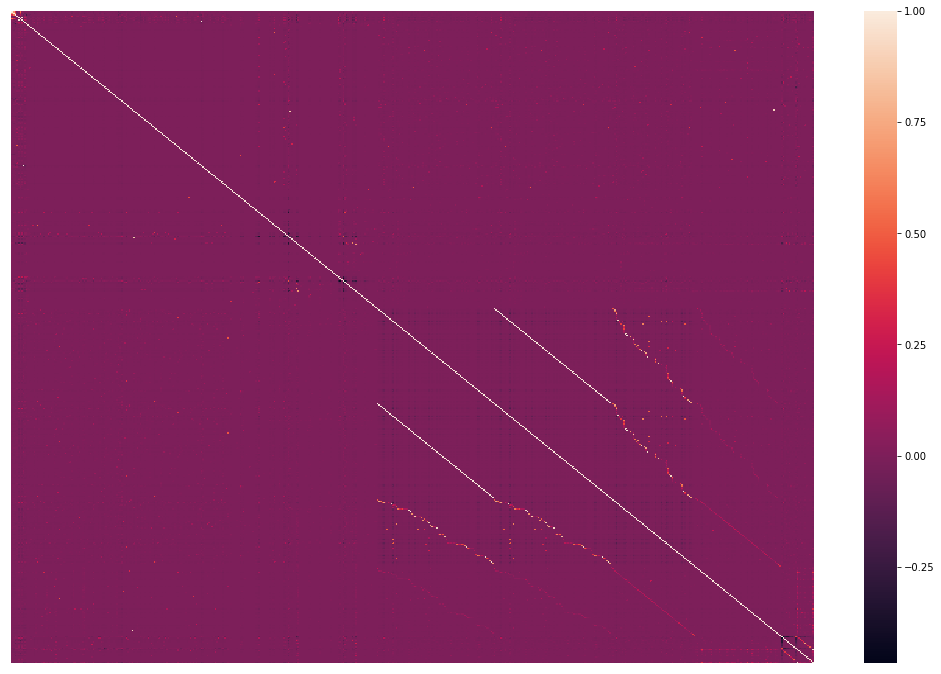

In [14]:
fig, ax = plt.subplots(figsize=(18,12))
sns.heatmap(datcorr, xticklabels=0, yticklabels=0)

#### The streaks of high correlation in the lower right portion of the heatmap is correlation between the states in which the primary and secondary jobs are located and the location cluster which the job is part of. I felt it prudent to keep both as there are points in the states which are not in the clusters and so there is potentially relevant information for prediction.

#### I divide the data into a training and testing sample and divide earners into high and low as two separate binary outputs to model

In [3]:
# Remake the training and test data
Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split(h1b, out)

hightrain = np.array([1 if a == 1 else 0 for a in ytrain])
hightest = np.array([1 if a == 1 else 0 for a in ytest])
lowtrain = np.array([1 if a == -1 else 0 for a in ytrain])
lowtest = np.array([1 if a == -1 else 0 for a in ytest])

### First approach - linear models

The first thing I tried is to fit some linear models to the data and see if they can predict the income status of the applicant.

The first model is a simple logistic regression, to serve as reference point for other models.

#### Logistic Regression

In [4]:
logreg = SGDClassifier(loss='log', penalty='none', tol=0.001, max_iter=50, verbose=2)
logreg.fit(Xtrain, hightrain)

-- Epoch 1
Norm: 132.17, NNZs: 510, Bias: -3.618749, T: 332182, Avg. loss: 0.351824
Total training time: 2.00 seconds.
-- Epoch 2
Norm: 133.52, NNZs: 510, Bias: -3.528228, T: 664364, Avg. loss: 0.215315
Total training time: 2.64 seconds.
-- Epoch 3
Norm: 134.33, NNZs: 510, Bias: -3.454302, T: 996546, Avg. loss: 0.210706
Total training time: 3.27 seconds.
-- Epoch 4
Norm: 134.91, NNZs: 510, Bias: -3.336403, T: 1328728, Avg. loss: 0.208269
Total training time: 3.90 seconds.
-- Epoch 5
Norm: 135.37, NNZs: 510, Bias: -3.355731, T: 1660910, Avg. loss: 0.206704
Total training time: 4.53 seconds.
-- Epoch 6
Norm: 135.74, NNZs: 510, Bias: -3.330282, T: 1993092, Avg. loss: 0.205550
Total training time: 5.16 seconds.
-- Epoch 7
Norm: 136.06, NNZs: 510, Bias: -3.315389, T: 2325274, Avg. loss: 0.204647
Total training time: 5.80 seconds.
Convergence after 7 epochs took 5.80 seconds


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=50, n_iter=None,
       n_jobs=1, penalty='none', power_t=0.5, random_state=None,
       shuffle=True, tol=0.001, verbose=2, warm_start=False)

In [5]:
logreg.score(Xtest, hightest)

0.92516797919225491

In [6]:
logreg.fit(Xtrain, lowtrain)

-- Epoch 1
Norm: 116.85, NNZs: 510, Bias: -0.260116, T: 332182, Avg. loss: 0.342340
Total training time: 0.96 seconds.
-- Epoch 2
Norm: 119.30, NNZs: 510, Bias: -0.450604, T: 664364, Avg. loss: 0.224028
Total training time: 1.58 seconds.
-- Epoch 3
Norm: 120.78, NNZs: 510, Bias: -0.625146, T: 996546, Avg. loss: 0.218593
Total training time: 2.19 seconds.
-- Epoch 4
Norm: 121.85, NNZs: 510, Bias: -0.769108, T: 1328728, Avg. loss: 0.215890
Total training time: 2.79 seconds.
-- Epoch 5
Norm: 122.67, NNZs: 510, Bias: -0.810081, T: 1660910, Avg. loss: 0.214022
Total training time: 3.39 seconds.
-- Epoch 6
Norm: 123.35, NNZs: 510, Bias: -0.890331, T: 1993092, Avg. loss: 0.212802
Total training time: 4.00 seconds.
-- Epoch 7
Norm: 123.93, NNZs: 510, Bias: -0.914312, T: 2325274, Avg. loss: 0.211801
Total training time: 4.60 seconds.
-- Epoch 8
Norm: 124.43, NNZs: 510, Bias: -0.945849, T: 2657456, Avg. loss: 0.210950
Total training time: 5.20 seconds.
Convergence after 8 epochs took 5.20 second

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=50, n_iter=None,
       n_jobs=1, penalty='none', power_t=0.5, random_state=None,
       shuffle=True, tol=0.001, verbose=2, warm_start=False)

In [7]:
logreg.score(Xtest, lowtest)

0.91297594104472224

So the most basic level of linear classifier can get ~90% accuracy, which we can consider as a baseline for models.

Next, I'll run a logistic regression with a lasso regularisation term, so as to shrink the number of features that are used in prediction. Here I run it with cross-validation, to find the optimal parameters of the model, using precision and recall as validation metrics.

#### Lasso Regression

In [47]:
tuned_parameters = [{'alpha': [0.0001, 0.0003, 0.0005, 0.0008]}]

lasso_cv = GridSearchCV(SGDClassifier(loss='log', penalty='l1', alpha=0.0005, tol=0.001, max_iter=80, verbose=2),
                        tuned_parameters, cv=5, scoring='recall')

In [5]:
lasso_cv.fit(Xtrain, hightrain)

-- Epoch 1
Norm: 202.20, NNZs: 105, Bias: -1.563155, T: 265745, Avg. loss: 0.331016
Total training time: 0.96 seconds.
-- Epoch 2
Norm: 204.17, NNZs: 106, Bias: -1.401787, T: 531490, Avg. loss: 0.211389
Total training time: 1.90 seconds.
-- Epoch 3
Norm: 205.28, NNZs: 100, Bias: -1.385789, T: 797235, Avg. loss: 0.208408
Total training time: 2.83 seconds.
-- Epoch 4
Norm: 206.06, NNZs: 95, Bias: -1.403089, T: 1062980, Avg. loss: 0.207037
Total training time: 3.76 seconds.
-- Epoch 5
Norm: 206.66, NNZs: 98, Bias: -1.435328, T: 1328725, Avg. loss: 0.206438
Total training time: 4.70 seconds.
Convergence after 5 epochs took 4.70 seconds
-- Epoch 1
Norm: 205.62, NNZs: 100, Bias: -1.374864, T: 265745, Avg. loss: 0.343984
Total training time: 0.94 seconds.
-- Epoch 2
Norm: 207.39, NNZs: 99, Bias: -1.467535, T: 531490, Avg. loss: 0.222015
Total training time: 1.87 seconds.
-- Epoch 3
Norm: 208.41, NNZs: 98, Bias: -1.513560, T: 797235, Avg. loss: 0.218123
Total training time: 2.80 seconds.
-- Ep

Norm: 96.53, NNZs: 63, Bias: -1.533651, T: 1328725, Avg. loss: 0.292783
Total training time: 4.59 seconds.
-- Epoch 6
Norm: 96.92, NNZs: 66, Bias: -1.525626, T: 1594470, Avg. loss: 0.291733
Total training time: 5.51 seconds.
-- Epoch 7
Norm: 97.24, NNZs: 66, Bias: -1.500302, T: 1860215, Avg. loss: 0.290814
Total training time: 6.43 seconds.
Convergence after 7 epochs took 6.43 seconds
-- Epoch 1
Norm: 90.98, NNZs: 66, Bias: -1.462359, T: 265745, Avg. loss: 0.340505
Total training time: 0.92 seconds.
-- Epoch 2
Norm: 92.47, NNZs: 65, Bias: -1.483747, T: 531490, Avg. loss: 0.303875
Total training time: 1.85 seconds.
-- Epoch 3
Norm: 93.35, NNZs: 65, Bias: -1.496328, T: 797235, Avg. loss: 0.299802
Total training time: 2.76 seconds.
-- Epoch 4
Norm: 93.97, NNZs: 66, Bias: -1.499001, T: 1062980, Avg. loss: 0.297492
Total training time: 3.69 seconds.
-- Epoch 5
Norm: 94.46, NNZs: 66, Bias: -1.486637, T: 1328725, Avg. loss: 0.295854
Total training time: 4.60 seconds.
-- Epoch 6
Norm: 94.85, N

-- Epoch 1
Norm: 199.05, NNZs: 94, Bias: -1.605083, T: 332182, Avg. loss: 0.307145
Total training time: 1.74 seconds.
-- Epoch 2
Norm: 201.12, NNZs: 101, Bias: -1.585641, T: 664364, Avg. loss: 0.213102
Total training time: 2.86 seconds.
-- Epoch 3
Norm: 202.27, NNZs: 102, Bias: -1.634043, T: 996546, Avg. loss: 0.210986
Total training time: 3.98 seconds.
-- Epoch 4
Norm: 203.07, NNZs: 99, Bias: -1.600429, T: 1328728, Avg. loss: 0.209839
Total training time: 5.11 seconds.
-- Epoch 5
Norm: 203.67, NNZs: 101, Bias: -1.576173, T: 1660910, Avg. loss: 0.209045
Total training time: 6.23 seconds.
Convergence after 5 epochs took 6.23 seconds


GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=50, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=80, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=0.001, verbose=2, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'alpha': [0.0001, 0.0003, 0.0005, 0.0008]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='recall', verbose=0)

In [8]:
lasso_cv.best_estimator_.score(Xtest, hightest)

0.92695614478722632

In [9]:
lasso_cv.best_params_

{'alpha': 0.0001}

In [10]:
lasso_cv.best_estimator_.coef_

array([[  9.40099833e-02,   8.01910513e-01,  -1.09901735e+00,
          1.22300154e-01,  -3.04573915e+00,   8.04076764e+01,
          0.00000000e+00,   7.99873670e+01,   0.00000000e+00,
          4.50484569e-01,   3.06292955e-01,   0.00000000e+00,
          0.00000000e+00,  -6.76664881e-02,   0.00000000e+00,
         -8.61798115e-01,   0.00000000e+00,   1.29878505e+00,
          1.21691244e-01,   0.00000000e+00,   0.00000000e+00,
          3.95292966e-01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.81284444e-01,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         -4.17740182e-01,   0.00000000e+00,  -3.42114109e-01,
          0.00000000e+00,  -2.09903026e+00,  -7.60426036e-01,
          0.00000000e+00,   0.00000000e+00,   1.70178705e+00,
        

In [12]:
# find the features with coefficients that aren't zero or tiny
lasso_high_cols = h1b.columns[np.where(np.abs(lasso_cv.best_estimator_.coef_.flatten()) > 0.05)[0]]
lasso_high_cols

Index(['lca_case_submit', 'decision_date', 'lca_case_employment_start_date',
       'lca_case_employment_end_date', 'total_workers', 'pw_1', 'pw_2',
       'seniority', 'E-3 Australian', '3I INFOTECH INC', 'ACCENTURE LLP',
       'AMAZON CORPORATE LLC', 'AMDOCS INC', 'APPLE INC', 'BLOOMBERG LP',
       'COGNIZANT TECHNOLOGY SOLUTIONS US CORPORATION',
       'COMPUNNEL SOFTWARE GROUP INC', 'CSC COVANSYS CORPORATION',
       'CUMMINS INC', 'DELOITTE CONSULTING LLP', 'ERNST  YOUNG US LLP',
       'GOOGLE INC', 'HCL AMERICA INC', 'HEADSTRONG SERVICES LLC',
       'IBM CORPORATION', 'IBM INDIA PRIVATE LIMITED',
       'IGATE TECHNOLOGIES INC', 'JPMORGAN CHASE  CO', 'KPMG LLP',
       'LARSEN  TOUBRO INFOTECH LIMITED',
       'MASTECH ALLIANCE INC A MASTECH HOLDINGS COMPANY',
       'MICROSOFT CORPORATION', 'MINDTREE LIMITED', 'MPHASIS CORPORATION',
       'ORION SYSTEMS INTEGRATORS INC', 'PAYPAL INC',
       'RANDSTAD TECHNOLOGIES LP', 'SALESFORCECOM INC', 'SAPIENT CORPORATION',
       'SAT

The prevailing wage variables are unsurprisingly part of the predictive variables in the lasso. So are the date variables for the applications, which may show that wages are increasing over time. Certain companies, locations, job categories and sectors are important too, specifically tech, finance, and engineering, which makes sense. Seniority of position is also a deciding factor, unsurprisingly, as is being Australian or at least applying via E-3.

In [48]:
# again for the low earners
lasso_cv.fit(Xtrain, lowtrain)

-- Epoch 1
Norm: 180.71, NNZs: 120, Bias: -0.535526, T: 265745, Avg. loss: 0.324888
Total training time: 1.22 seconds.
-- Epoch 2
Norm: 183.29, NNZs: 127, Bias: -0.803551, T: 531490, Avg. loss: 0.226036
Total training time: 2.18 seconds.
-- Epoch 3
Norm: 184.75, NNZs: 131, Bias: -0.854690, T: 797235, Avg. loss: 0.222588
Total training time: 3.13 seconds.
-- Epoch 4
Norm: 185.77, NNZs: 128, Bias: -0.800244, T: 1062980, Avg. loss: 0.220795
Total training time: 4.09 seconds.
-- Epoch 5
Norm: 186.55, NNZs: 139, Bias: -0.827775, T: 1328725, Avg. loss: 0.219573
Total training time: 5.04 seconds.
-- Epoch 6
Norm: 187.18, NNZs: 138, Bias: -0.862575, T: 1594470, Avg. loss: 0.218734
Total training time: 5.99 seconds.
Convergence after 6 epochs took 5.99 seconds
-- Epoch 1
Norm: 179.95, NNZs: 129, Bias: -0.813357, T: 265745, Avg. loss: 0.322801
Total training time: 0.97 seconds.
-- Epoch 2
Norm: 182.58, NNZs: 125, Bias: -0.888669, T: 531490, Avg. loss: 0.225213
Total training time: 1.93 seconds.


-- Epoch 1
Norm: 79.89, NNZs: 67, Bias: -0.130190, T: 265745, Avg. loss: 0.332277
Total training time: 0.93 seconds.
-- Epoch 2
Norm: 80.97, NNZs: 66, Bias: -0.152844, T: 531490, Avg. loss: 0.307535
Total training time: 1.88 seconds.
-- Epoch 3
Norm: 81.61, NNZs: 66, Bias: -0.166863, T: 797235, Avg. loss: 0.304896
Total training time: 2.81 seconds.
-- Epoch 4
Norm: 82.06, NNZs: 65, Bias: -0.181270, T: 1062980, Avg. loss: 0.303242
Total training time: 3.75 seconds.
-- Epoch 5
Norm: 82.41, NNZs: 64, Bias: -0.171596, T: 1328725, Avg. loss: 0.302164
Total training time: 4.68 seconds.
-- Epoch 6
Norm: 82.70, NNZs: 66, Bias: -0.195754, T: 1594470, Avg. loss: 0.301299
Total training time: 5.61 seconds.
Convergence after 6 epochs took 5.61 seconds
-- Epoch 1
Norm: 81.25, NNZs: 61, Bias: -0.306440, T: 265745, Avg. loss: 0.330510
Total training time: 0.93 seconds.
-- Epoch 2
Norm: 82.34, NNZs: 61, Bias: -0.380366, T: 531490, Avg. loss: 0.303703
Total training time: 1.86 seconds.
-- Epoch 3
Norm:

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=50, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=80, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=0.001, verbose=2, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'alpha': [0.0001, 0.0003, 0.0005, 0.0008]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='recall', verbose=0)

In [49]:
lasso_cv.best_estimator_.score(Xtest, lowtest)

0.90851455819666205

In [50]:
lasso_cv.best_params_

{'alpha': 0.0001}

In [51]:
# find the features with non-zero coefficients in the lasso
lasso_low_cols = h1b.columns[np.where(np.abs(lasso_cv.best_estimator_.coef_.flatten()) > 0.05)[0]]
lasso_low_cols.tolist()

['lca_case_submit',
 'decision_date',
 'lca_case_employment_start_date',
 'total_workers',
 'pw_1',
 'yr_source_pub_1',
 'pw_2',
 'n_unique_addrs',
 'seniority',
 'H-1B1 Singapore',
 '3I INFOTECH INC',
 'ACCENTURE LLP',
 'AMERICAN INFORMATION TECHNOLOGY CORPORATION',
 'ASTIR IT SOLUTIONS INC',
 'BUSINESS INTELLI SOLUTIONS INC',
 'CAPGEMINI FINANCIAL SERVICES USA INC LEGACY KANB',
 'CERNER CORPORATION',
 'CIBER INC',
 'COGNIZANT TECHNOLOGY SOLUTIONS US CORPORATION',
 'COMPUTER SCIENCES CORPORATION',
 'CSC COVANSYS CORPORATION',
 'DELOITTE  TOUCHE LLP',
 'DELOITTE CONSULTING LLP',
 'GOOGLE INC',
 'HCL AMERICA INC',
 'HCL GLOBAL SYSTEMS INC',
 'HORIZON TECHNOLOGIES INC',
 'HTC GLOBAL SERVICES INC',
 'IBM CORPORATION',
 'IBM INDIA PRIVATE LIMITED',
 'IGATE TECHNOLOGIES INC',
 'INFOSYS LIMITED',
 'INFOSYTECH SOLUTIONS INC',
 'KFORCE INC',
 'KPIT INFOSYSTEMS INC',
 'KPMG LLP',
 'LARSEN  TOUBRO INFOTECH LIMITED',
 'LARSEN  TOUBRO TECHNOLOGY SERVICES LTD',
 'LT TECHNOLOGY SERVICES LIMITED',
 '

The lasso doesn't find as few features that it can restrict the space down to for lower earners. A lot of the features overlap but a couple of interesting and expected additions are Singaporean citizens, and Indian contracting companies like INFOSYS.

In [17]:
lasso_cv = GridSearchCV(SGDClassifier(loss='log', penalty='l1', alpha=0.0001, tol=0.001, max_iter=80, verbose=2),
                        tuned_parameters, cv=5, scoring='precision')

In [18]:
lasso_cv.fit(Xtrain, hightrain)

-- Epoch 1
Norm: 199.40, NNZs: 91, Bias: -1.472044, T: 265745, Avg. loss: 0.326983
Total training time: 0.96 seconds.
-- Epoch 2
Norm: 201.42, NNZs: 91, Bias: -1.520246, T: 531490, Avg. loss: 0.212861
Total training time: 1.92 seconds.
-- Epoch 3
Norm: 202.54, NNZs: 94, Bias: -1.423206, T: 797235, Avg. loss: 0.210322
Total training time: 2.87 seconds.
-- Epoch 4
Norm: 203.32, NNZs: 90, Bias: -1.460102, T: 1062980, Avg. loss: 0.209166
Total training time: 3.82 seconds.
-- Epoch 5
Norm: 203.91, NNZs: 92, Bias: -1.463567, T: 1328725, Avg. loss: 0.208426
Total training time: 4.77 seconds.
Convergence after 5 epochs took 4.77 seconds
-- Epoch 1
Norm: 198.76, NNZs: 100, Bias: -1.442103, T: 265745, Avg. loss: 0.335661
Total training time: 0.96 seconds.
-- Epoch 2
Norm: 200.82, NNZs: 102, Bias: -1.383525, T: 531490, Avg. loss: 0.216460
Total training time: 1.92 seconds.
-- Epoch 3
Norm: 201.96, NNZs: 100, Bias: -1.413023, T: 797235, Avg. loss: 0.213498
Total training time: 2.86 seconds.
-- Epo

Norm: 95.92, NNZs: 68, Bias: -1.548088, T: 2125960, Avg. loss: 0.294694
Total training time: 7.25 seconds.
Convergence after 8 epochs took 7.25 seconds
-- Epoch 1
Norm: 90.93, NNZs: 66, Bias: -1.463161, T: 265745, Avg. loss: 0.341057
Total training time: 0.91 seconds.
-- Epoch 2
Norm: 92.44, NNZs: 63, Bias: -1.557239, T: 531490, Avg. loss: 0.307469
Total training time: 1.82 seconds.
-- Epoch 3
Norm: 93.32, NNZs: 64, Bias: -1.546948, T: 797235, Avg. loss: 0.303492
Total training time: 2.72 seconds.
-- Epoch 4
Norm: 93.94, NNZs: 63, Bias: -1.536886, T: 1062980, Avg. loss: 0.301131
Total training time: 3.63 seconds.
-- Epoch 5
Norm: 94.42, NNZs: 63, Bias: -1.494621, T: 1328725, Avg. loss: 0.299414
Total training time: 4.53 seconds.
-- Epoch 6
Norm: 94.81, NNZs: 63, Bias: -1.523173, T: 1594470, Avg. loss: 0.298130
Total training time: 5.43 seconds.
-- Epoch 7
Norm: 95.14, NNZs: 64, Bias: -1.521009, T: 1860215, Avg. loss: 0.297103
Total training time: 6.34 seconds.
-- Epoch 8
Norm: 95.43, N

-- Epoch 1
Norm: 114.42, NNZs: 77, Bias: -1.629526, T: 332182, Avg. loss: 0.311801
Total training time: 1.15 seconds.
-- Epoch 2
Norm: 116.39, NNZs: 74, Bias: -1.581952, T: 664364, Avg. loss: 0.266820
Total training time: 2.30 seconds.
-- Epoch 3
Norm: 117.53, NNZs: 68, Bias: -1.645618, T: 996546, Avg. loss: 0.263377
Total training time: 3.45 seconds.
-- Epoch 4
Norm: 118.32, NNZs: 74, Bias: -1.628439, T: 1328728, Avg. loss: 0.261305
Total training time: 4.59 seconds.
-- Epoch 5
Norm: 118.93, NNZs: 73, Bias: -1.582139, T: 1660910, Avg. loss: 0.259863
Total training time: 5.74 seconds.
-- Epoch 6
Norm: 119.43, NNZs: 73, Bias: -1.611813, T: 1993092, Avg. loss: 0.258705
Total training time: 6.88 seconds.
-- Epoch 7
Norm: 119.84, NNZs: 70, Bias: -1.582278, T: 2325274, Avg. loss: 0.257892
Total training time: 8.02 seconds.
Convergence after 7 epochs took 8.02 seconds


GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=80, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=0.001, verbose=2, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'alpha': [0.0001, 0.0003, 0.0005, 0.0008]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='precision', verbose=0)

In [19]:
lasso_cv.best_estimator_.score(Xtest, hightest)

0.90110902391445702

In [20]:
lasso_cv.best_params_

{'alpha': 0.0003}

In [21]:
lasso_high_cols_prec = h1b.columns[np.where(lasso_cv.best_estimator_.coef_.flatten() != 0)[0]]
lasso_high_cols_prec

Index(['decision_date', 'lca_case_employment_start_date',
       'lca_case_employment_end_date', 'pw_1', 'yr_source_pub_1', 'pw_2',
       'n_unique_addrs', 'seniority', 'E-3 Australian', 'ACCENTURE LLP',
       'APPLE INC', 'COGNIZANT TECHNOLOGY SOLUTIONS US CORPORATION',
       'CUMMINS INC', 'DELOITTE CONSULTING LLP', 'ERNST  YOUNG US LLP',
       'GOOGLE INC', 'HCL AMERICA INC', 'IBM CORPORATION',
       'IBM INDIA PRIVATE LIMITED', 'IGATE TECHNOLOGIES INC',
       'INFOSYS LIMITED', 'JPMORGAN CHASE  CO',
       'LARSEN  TOUBRO INFOTECH LIMITED', 'MICROSOFT CORPORATION',
       'RANDSTAD TECHNOLOGIES LP', 'SALESFORCECOM INC', 'SYMANTEC CORPORATION',
       'TATA CONSULTANCY SERVICES LIMITED', 'TECH MAHINDRA  AMERICAS INC',
       'VMWARE INC', 'WIPRO LIMITED', 'sector_21', 'sector_45', 'sector_51',
       'sector_52', 'sector_54', 'sector_56', 'sector_61', 'soc_11', 'soc_13',
       'soc_15', 'soc_23', 'soc_25', 'soc_29', 'soc_41', 'work1_4.0',
       'work1_5.0', 'work1_10.0', 'wo

In [22]:
lasso_cv.fit(Xtrain, lowtrain)

-- Epoch 1
Norm: 180.49, NNZs: 124, Bias: -0.970463, T: 265745, Avg. loss: 0.327539
Total training time: 0.94 seconds.
-- Epoch 2
Norm: 182.99, NNZs: 127, Bias: -0.723767, T: 531490, Avg. loss: 0.225645
Total training time: 1.87 seconds.
-- Epoch 3
Norm: 184.42, NNZs: 129, Bias: -0.965300, T: 797235, Avg. loss: 0.222208
Total training time: 2.80 seconds.
-- Epoch 4
Norm: 185.42, NNZs: 129, Bias: -0.808156, T: 1062980, Avg. loss: 0.220415
Total training time: 3.72 seconds.
-- Epoch 5
Norm: 186.19, NNZs: 129, Bias: -0.761176, T: 1328725, Avg. loss: 0.219248
Total training time: 4.65 seconds.
-- Epoch 6
Norm: 186.82, NNZs: 130, Bias: -0.937988, T: 1594470, Avg. loss: 0.218422
Total training time: 5.57 seconds.
Convergence after 6 epochs took 5.57 seconds
-- Epoch 1
Norm: 170.29, NNZs: 117, Bias: -0.654808, T: 265745, Avg. loss: 0.318713
Total training time: 0.93 seconds.
-- Epoch 2
Norm: 173.13, NNZs: 127, Bias: -0.934443, T: 531490, Avg. loss: 0.224203
Total training time: 1.85 seconds.


Norm: 83.65, NNZs: 60, Bias: -0.071111, T: 1062980, Avg. loss: 0.300524
Total training time: 3.60 seconds.
-- Epoch 5
Norm: 84.00, NNZs: 60, Bias: -0.096685, T: 1328725, Avg. loss: 0.299449
Total training time: 4.50 seconds.
-- Epoch 6
Norm: 84.29, NNZs: 60, Bias: -0.090853, T: 1594470, Avg. loss: 0.298634
Total training time: 5.40 seconds.
Convergence after 6 epochs took 5.40 seconds
-- Epoch 1
Norm: 80.46, NNZs: 65, Bias: -0.279891, T: 265745, Avg. loss: 0.331902
Total training time: 0.91 seconds.
-- Epoch 2
Norm: 81.52, NNZs: 63, Bias: -0.321904, T: 531490, Avg. loss: 0.306508
Total training time: 1.82 seconds.
-- Epoch 3
Norm: 82.14, NNZs: 64, Bias: -0.317245, T: 797235, Avg. loss: 0.303923
Total training time: 2.73 seconds.
-- Epoch 4
Norm: 82.59, NNZs: 64, Bias: -0.337132, T: 1062980, Avg. loss: 0.302423
Total training time: 3.64 seconds.
-- Epoch 5
Norm: 82.94, NNZs: 64, Bias: -0.332537, T: 1328725, Avg. loss: 0.301393
Total training time: 4.55 seconds.
-- Epoch 6
Norm: 83.22, N

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=80, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=0.001, verbose=2, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'alpha': [0.0001, 0.0003, 0.0005, 0.0008]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='precision', verbose=0)

In [23]:
lasso_cv.best_estimator_.score(Xtest, lowtest)

0.90629289791200063

In [24]:
lasso_cv.best_params_

{'alpha': 0.0001}

In [27]:
lasso_low_cols_prec = h1b.columns[np.where(np.abs(lasso_cv.best_estimator_.coef_.flatten()) > 0.05)[0]]
lasso_low_cols_prec

Index(['lca_case_submit', 'decision_date', 'lca_case_employment_start_date',
       'total_workers', 'pw_1', 'yr_source_pub_1', 'pw_2', 'n_unique_addrs',
       'seniority', 'H-1B1 Singapore',
       ...
       'work2_NJ', 'work2_TX', 'work2_VA', 'radford_1', 'owl_1', 'cba_1',
       'aamc_1', 'oes_1', 'oflc_2', 'second_loc'],
      dtype='object', length=109)

Precision and recall both result in similar accuracies, and get results on par with the non-penalised regression, while significantly reducing the number of relevant features. We can see the difference in how the features mattered for either high or low earners:

In [28]:
# features which were only important for high earners and not for low earners
set(lasso_high_cols) - set(lasso_low_cols)

{'AMAZON CORPORATE LLC',
 'AMDOCS INC',
 'APPLE INC',
 'BLOOMBERG LP',
 'COMPUNNEL SOFTWARE GROUP INC',
 'CUMMINS INC',
 'E-3 Australian',
 'ERNST  YOUNG US LLP',
 'GOOGLE INC',
 'HEADSTRONG SERVICES LLC',
 'ORION SYSTEMS INTEGRATORS INC',
 'PAYPAL INC',
 'RANDSTAD TECHNOLOGIES LP',
 'SALESFORCECOM INC',
 'SAPIENT CORPORATION',
 'SYMANTEC CORPORATION',
 'SYSTEM SOFT TECHNOLOGIES LLC',
 'VMWARE INC',
 'lca_case_employment_end_date',
 'sector_45',
 'soc_13',
 'soc_23',
 'soc_29',
 'soc_43',
 'work1_35.0',
 'work1_5.0',
 'work1_65.0',
 'work1_73.0',
 'work1_CO',
 'work1_DE',
 'work1_IA',
 'work1_NY',
 'work1_OR',
 'work1_PA',
 'work1_VA',
 'work2_35.0',
 'work2_5.0',
 'work2_65.0',
 'work2_73.0',
 'work2_WA'}

Here we can see that those companies which are good predictors of high earners but not of low earners include companies one would consider to pay very well - Google, Apple, Amazon. SOC code 13 is the code for finance jobs, which one expects to be paid well in too. I suppose it is also reasonable to believe that Australians don't come to the USA to work if they are working in a low paying job.

In [29]:
# features which mattered for low earners and not for high earners
set(lasso_low_cols) - set(lasso_high_cols)

{'AMERICAN INFORMATION TECHNOLOGY CORPORATION',
 'ASTIR IT SOLUTIONS INC',
 'BUSINESS INTELLI SOLUTIONS INC',
 'CAPGEMINI FINANCIAL SERVICES USA INC LEGACY KANB',
 'CERNER CORPORATION',
 'COMPUTER SCIENCES CORPORATION',
 'DELOITTE  TOUCHE LLP',
 'H-1B1 Singapore',
 'HCL GLOBAL SYSTEMS INC',
 'HORIZON TECHNOLOGIES INC',
 'HTC GLOBAL SERVICES INC',
 'INFOSYS LIMITED',
 'INFOSYTECH SOLUTIONS INC',
 'INFOTECH ENTERPRISES AMERICA INC',
 'ITC INFOTECH USA INC',
 'KFORCE INC',
 'KPIT INFOSYSTEMS INC',
 'LARSEN  TOUBRO TECHNOLOGY SERVICES LTD',
 'LT TECHNOLOGY SERVICES LIMITED',
 'PERSISTENT SYSTEMS INC',
 'PHOTON INFOTECH INC',
 'POLARIS SOFTWARE LAB INDIA LIMITED',
 'RELIABLE SOFTWARE RESOURCES INC',
 'SPLENDTEK INC',
 'SYNTEL CONSULTING INC',
 'THE BOARD OF TRUSTEES OF THE LELAND STANFORD JR',
 'UST GLOBAL INC',
 'VEDICSOFT',
 'VSOFT CONSULTING GROUP INC',
 'YASH TECHNOLOGIES INC',
 'n_unique_addrs',
 'owl_1',
 'radford_1',
 'sector_22',
 'sector_42',
 'sector_62',
 'sector_72',
 'soc_11',


As noted before, some of the companies that are predictors for low earners and not for high earners seem to be Indian companies that are known to be responsible for a huge number of H-1Bs (as shown in other work e.g. http://projects.sfchronicle.com/2016/visas/). These companies also have many offices, which may explain the inclusion of *n_unique_addrs* in this set.

Just for kicks, I'll try a linear SVM with an elastic net regularisation now to see if it can do any better.

#### Linear SVM with elasticnet

In [30]:
# svm with elasticnet regularisation
tuned_parameters = [{'alpha': [0.00001, 0.00005, 0.0001],
                     'l1_ratio': [0.3, 0.4, 0.5, 0.6, 0.7]}]

enetsvm = GridSearchCV(SGDClassifier(loss='hinge', penalty='elasticnet', alpha=0.0001, l1_ratio=0.3, tol=0.001, max_iter=80, verbose=2),
                       tuned_parameters, cv=5, scoring='recall')

In [31]:
enetsvm.fit(Xtrain, hightrain)

-- Epoch 1
Norm: 230.46, NNZs: 278, Bias: -2.750441, T: 265745, Avg. loss: 1.359350
Total training time: 0.95 seconds.
-- Epoch 2
Norm: 187.34, NNZs: 251, Bias: -2.098050, T: 531490, Avg. loss: 0.254882
Total training time: 1.80 seconds.
-- Epoch 3
Norm: 165.73, NNZs: 242, Bias: -1.314817, T: 797235, Avg. loss: 0.230563
Total training time: 2.67 seconds.
-- Epoch 4
Norm: 152.11, NNZs: 265, Bias: -1.238705, T: 1062980, Avg. loss: 0.221168
Total training time: 3.53 seconds.
-- Epoch 5
Norm: 142.55, NNZs: 271, Bias: -1.252562, T: 1328725, Avg. loss: 0.215722
Total training time: 4.40 seconds.
-- Epoch 6
Norm: 135.40, NNZs: 293, Bias: -1.139603, T: 1594470, Avg. loss: 0.212710
Total training time: 5.30 seconds.
-- Epoch 7
Norm: 129.73, NNZs: 285, Bias: -1.376053, T: 1860215, Avg. loss: 0.210347
Total training time: 6.21 seconds.
-- Epoch 8
Norm: 125.15, NNZs: 304, Bias: -1.275368, T: 2125960, Avg. loss: 0.208107
Total training time: 7.12 seconds.
-- Epoch 9
Norm: 121.31, NNZs: 315, Bias: -

Norm: 207.06, NNZs: 252, Bias: -1.766607, T: 531492, Avg. loss: 0.253095
Total training time: 1.79 seconds.
-- Epoch 3
Norm: 183.29, NNZs: 264, Bias: -2.000829, T: 797238, Avg. loss: 0.225135
Total training time: 2.65 seconds.
-- Epoch 4
Norm: 168.13, NNZs: 270, Bias: -1.227247, T: 1062984, Avg. loss: 0.218583
Total training time: 3.52 seconds.
-- Epoch 5
Norm: 157.60, NNZs: 272, Bias: -1.417011, T: 1328730, Avg. loss: 0.213369
Total training time: 4.41 seconds.
-- Epoch 6
Norm: 149.71, NNZs: 278, Bias: -1.351115, T: 1594476, Avg. loss: 0.209565
Total training time: 5.29 seconds.
-- Epoch 7
Norm: 143.44, NNZs: 283, Bias: -1.296594, T: 1860222, Avg. loss: 0.208172
Total training time: 6.19 seconds.
-- Epoch 8
Norm: 138.38, NNZs: 311, Bias: -1.211279, T: 2125968, Avg. loss: 0.206026
Total training time: 7.09 seconds.
-- Epoch 9
Norm: 134.24, NNZs: 294, Bias: -1.147343, T: 2391714, Avg. loss: 0.204139
Total training time: 8.00 seconds.
-- Epoch 10
Norm: 130.60, NNZs: 309, Bias: -1.391880,

Norm: 187.72, NNZs: 261, Bias: -1.396014, T: 1062984, Avg. loss: 0.214185
Total training time: 3.51 seconds.
-- Epoch 5
Norm: 175.97, NNZs: 267, Bias: -2.103881, T: 1328730, Avg. loss: 0.209420
Total training time: 4.39 seconds.
-- Epoch 6
Norm: 167.30, NNZs: 270, Bias: -1.831655, T: 1594476, Avg. loss: 0.204788
Total training time: 5.29 seconds.
-- Epoch 7
Norm: 160.35, NNZs: 281, Bias: -1.355312, T: 1860222, Avg. loss: 0.203988
Total training time: 6.17 seconds.
Convergence after 7 epochs took 6.17 seconds
-- Epoch 1
Norm: 335.96, NNZs: 244, Bias: -3.516600, T: 265745, Avg. loss: 1.263563
Total training time: 0.93 seconds.
-- Epoch 2
Norm: 274.02, NNZs: 239, Bias: -2.621523, T: 531490, Avg. loss: 0.254621
Total training time: 1.80 seconds.
-- Epoch 3
Norm: 242.54, NNZs: 258, Bias: -1.949190, T: 797235, Avg. loss: 0.224062
Total training time: 2.67 seconds.
-- Epoch 4
Norm: 222.61, NNZs: 267, Bias: -1.812455, T: 1062980, Avg. loss: 0.214581
Total training time: 3.55 seconds.
-- Epoch 

Norm: 244.88, NNZs: 269, Bias: -1.634630, T: 1594470, Avg. loss: 0.207285
Total training time: 5.18 seconds.
-- Epoch 7
Norm: 234.94, NNZs: 276, Bias: -1.679211, T: 1860215, Avg. loss: 0.204057
Total training time: 6.04 seconds.
-- Epoch 8
Norm: 226.74, NNZs: 286, Bias: -1.576435, T: 2125960, Avg. loss: 0.202100
Total training time: 6.91 seconds.
-- Epoch 9
Norm: 219.85, NNZs: 279, Bias: -1.560316, T: 2391705, Avg. loss: 0.200130
Total training time: 7.80 seconds.
-- Epoch 10
Norm: 213.97, NNZs: 290, Bias: -1.395310, T: 2657450, Avg. loss: 0.198576
Total training time: 8.68 seconds.
-- Epoch 11
Norm: 208.85, NNZs: 279, Bias: -1.701254, T: 2923195, Avg. loss: 0.197241
Total training time: 9.56 seconds.
-- Epoch 12
Norm: 204.33, NNZs: 283, Bias: -1.049554, T: 3188940, Avg. loss: 0.197217
Total training time: 10.45 seconds.
Convergence after 12 epochs took 10.45 seconds
-- Epoch 1
Norm: 394.31, NNZs: 246, Bias: -3.053020, T: 265746, Avg. loss: 1.258385
Total training time: 0.90 seconds.
-

Norm: 56.69, NNZs: 267, Bias: -1.083570, T: 1328730, Avg. loss: 0.232559
Total training time: 4.40 seconds.
-- Epoch 6
Norm: 55.43, NNZs: 275, Bias: -1.213101, T: 1594476, Avg. loss: 0.231473
Total training time: 5.31 seconds.
-- Epoch 7
Norm: 54.47, NNZs: 274, Bias: -1.058929, T: 1860222, Avg. loss: 0.230683
Total training time: 6.22 seconds.
Convergence after 7 epochs took 6.22 seconds
-- Epoch 1
Norm: 76.47, NNZs: 204, Bias: -1.246643, T: 265746, Avg. loss: 0.538034
Total training time: 0.89 seconds.
-- Epoch 2
Norm: 66.29, NNZs: 242, Bias: -1.106330, T: 531492, Avg. loss: 0.241575
Total training time: 1.76 seconds.
-- Epoch 3
Norm: 61.50, NNZs: 244, Bias: -1.343903, T: 797238, Avg. loss: 0.236537
Total training time: 2.65 seconds.
-- Epoch 4
Norm: 58.72, NNZs: 254, Bias: -0.972110, T: 1062984, Avg. loss: 0.233631
Total training time: 3.54 seconds.
-- Epoch 5
Norm: 56.91, NNZs: 258, Bias: -1.010355, T: 1328730, Avg. loss: 0.232329
Total training time: 4.44 seconds.
-- Epoch 6
Norm: 

Norm: 77.44, NNZs: 192, Bias: -0.977900, T: 797238, Avg. loss: 0.224509
Total training time: 2.58 seconds.
-- Epoch 4
Norm: 73.44, NNZs: 221, Bias: -1.130029, T: 1062984, Avg. loss: 0.222277
Total training time: 3.45 seconds.
-- Epoch 5
Norm: 70.74, NNZs: 224, Bias: -1.176238, T: 1328730, Avg. loss: 0.221032
Total training time: 4.32 seconds.
-- Epoch 6
Norm: 68.77, NNZs: 229, Bias: -0.962346, T: 1594476, Avg. loss: 0.220267
Total training time: 5.20 seconds.
Convergence after 6 epochs took 5.20 seconds
-- Epoch 1
Norm: 113.83, NNZs: 175, Bias: -1.352785, T: 265745, Avg. loss: 0.490232
Total training time: 0.83 seconds.
-- Epoch 2
Norm: 98.36, NNZs: 183, Bias: -0.917667, T: 531490, Avg. loss: 0.220552
Total training time: 1.64 seconds.
-- Epoch 3
Norm: 90.75, NNZs: 189, Bias: -1.268296, T: 797235, Avg. loss: 0.216399
Total training time: 2.47 seconds.
-- Epoch 4
Norm: 86.01, NNZs: 206, Bias: -1.176184, T: 1062980, Avg. loss: 0.215238
Total training time: 3.31 seconds.
-- Epoch 5
Norm: 

Norm: 39.35, NNZs: 247, Bias: -1.045027, T: 1328725, Avg. loss: 0.256756
Total training time: 4.32 seconds.
-- Epoch 6
Norm: 38.85, NNZs: 253, Bias: -1.025832, T: 1594470, Avg. loss: 0.256191
Total training time: 5.21 seconds.
Convergence after 6 epochs took 5.21 seconds
-- Epoch 1
Norm: 48.62, NNZs: 208, Bias: -1.092531, T: 265746, Avg. loss: 0.435928
Total training time: 0.87 seconds.
-- Epoch 2
Norm: 43.45, NNZs: 228, Bias: -1.031493, T: 531492, Avg. loss: 0.263627
Total training time: 1.74 seconds.
-- Epoch 3
Norm: 41.35, NNZs: 245, Bias: -1.117123, T: 797238, Avg. loss: 0.258738
Total training time: 2.64 seconds.
-- Epoch 4
Norm: 40.19, NNZs: 244, Bias: -1.074321, T: 1062984, Avg. loss: 0.256532
Total training time: 3.53 seconds.
-- Epoch 5
Norm: 39.44, NNZs: 266, Bias: -0.968310, T: 1328730, Avg. loss: 0.255915
Total training time: 4.42 seconds.
Convergence after 5 epochs took 4.42 seconds
-- Epoch 1
Norm: 48.53, NNZs: 203, Bias: -1.312190, T: 265746, Avg. loss: 0.437656
Total tr

Norm: 55.48, NNZs: 174, Bias: -1.099355, T: 531492, Avg. loss: 0.247819
Total training time: 1.61 seconds.
-- Epoch 3
Norm: 52.17, NNZs: 185, Bias: -0.884718, T: 797238, Avg. loss: 0.244385
Total training time: 2.43 seconds.
-- Epoch 4
Norm: 50.26, NNZs: 186, Bias: -0.948955, T: 1062984, Avg. loss: 0.243130
Total training time: 3.26 seconds.
-- Epoch 5
Norm: 49.01, NNZs: 200, Bias: -1.101990, T: 1328730, Avg. loss: 0.242160
Total training time: 4.09 seconds.
Convergence after 5 epochs took 4.09 seconds
-- Epoch 1
Norm: 73.57, NNZs: 156, Bias: -0.886833, T: 265745, Avg. loss: 0.391204
Total training time: 0.79 seconds.
-- Epoch 2
Norm: 65.15, NNZs: 161, Bias: -1.101948, T: 531490, Avg. loss: 0.237816
Total training time: 1.58 seconds.
-- Epoch 3
Norm: 61.20, NNZs: 173, Bias: -1.037818, T: 797235, Avg. loss: 0.234998
Total training time: 2.37 seconds.
-- Epoch 4
Norm: 58.83, NNZs: 187, Bias: -0.988368, T: 1062980, Avg. loss: 0.233971
Total training time: 3.17 seconds.
-- Epoch 5
Norm: 57

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.3, learning_rate='optimal',
       loss='hinge', max_iter=80, n_iter=None, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       tol=0.001, verbose=2, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'alpha': [1e-05, 5e-05, 0.0001], 'l1_ratio': [0.3, 0.4, 0.5, 0.6, 0.7]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='recall', verbose=0)

In [32]:
enetsvm.best_estimator_.score(Xtest, hightest)

0.91270500686366596

In [33]:
enetsvm.best_params_

{'alpha': 1e-05, 'l1_ratio': 0.5}

In [34]:
enetsvm.best_estimator_.coef_

array([[  0.00000000e+00,   6.07196216e-01,  -4.66375012e-01,
          2.39497123e-01,  -3.83389129e+00,   6.82215605e+01,
          0.00000000e+00,   6.74329076e+01,   0.00000000e+00,
          2.16428786e-01,   1.42988190e-01,   3.24734462e-01,
         -5.38298591e-02,  -6.32179042e-01,   7.58687966e-01,
         -7.13100034e-01,  -1.68400820e-01,   2.08008903e+00,
          6.77899996e-01,   6.70613093e-01,  -3.73163479e-01,
          9.43607982e-01,  -3.16471267e-01,  -6.82163262e-01,
          1.68060187e-01,   1.15814934e+00,   0.00000000e+00,
         -2.17450951e-01,  -4.06169894e-01,   0.00000000e+00,
          0.00000000e+00,   3.64814506e-01,   2.73377276e-01,
          3.15946601e-01,   4.21805871e-01,   3.87614322e-01,
          1.00772357e+00,  -6.30772122e-01,  -2.26652912e-01,
         -3.03193505e-01,  -1.08016880e+00,   0.00000000e+00,
         -6.56038564e-01,  -6.92547611e-01,  -8.94280532e-01,
         -7.57571966e-01,   5.86397382e-01,   1.10909983e+00,
        

In [35]:
enetsvm.fit(Xtrain, lowtrain)

-- Epoch 1
Norm: 217.67, NNZs: 301, Bias: -1.232380, T: 265745, Avg. loss: 1.274082
Total training time: 0.98 seconds.
-- Epoch 2
Norm: 182.94, NNZs: 264, Bias: -1.425117, T: 531490, Avg. loss: 0.272669
Total training time: 1.89 seconds.
-- Epoch 3
Norm: 163.55, NNZs: 271, Bias: -1.529330, T: 797235, Avg. loss: 0.240771
Total training time: 2.80 seconds.
-- Epoch 4
Norm: 151.23, NNZs: 282, Bias: -1.659617, T: 1062980, Avg. loss: 0.227579
Total training time: 3.72 seconds.
-- Epoch 5
Norm: 142.45, NNZs: 286, Bias: -1.060555, T: 1328725, Avg. loss: 0.221693
Total training time: 4.63 seconds.
-- Epoch 6
Norm: 135.60, NNZs: 298, Bias: -1.085113, T: 1594470, Avg. loss: 0.218733
Total training time: 5.56 seconds.
-- Epoch 7
Norm: 130.18, NNZs: 309, Bias: -0.830624, T: 1860215, Avg. loss: 0.216443
Total training time: 6.50 seconds.
-- Epoch 8
Norm: 125.76, NNZs: 315, Bias: -1.433158, T: 2125960, Avg. loss: 0.214132
Total training time: 7.45 seconds.
-- Epoch 9
Norm: 122.03, NNZs: 322, Bias: -

Norm: 130.62, NNZs: 311, Bias: -1.077346, T: 2923195, Avg. loss: 0.207214
Total training time: 10.08 seconds.
Convergence after 11 epochs took 10.08 seconds
-- Epoch 1
Norm: 243.90, NNZs: 251, Bias: -2.292955, T: 265745, Avg. loss: 1.244176
Total training time: 0.96 seconds.
-- Epoch 2
Norm: 204.61, NNZs: 245, Bias: -1.421151, T: 531490, Avg. loss: 0.266880
Total training time: 1.85 seconds.
-- Epoch 3
Norm: 182.28, NNZs: 269, Bias: -1.679890, T: 797235, Avg. loss: 0.238826
Total training time: 2.75 seconds.
-- Epoch 4
Norm: 168.18, NNZs: 267, Bias: -1.321460, T: 1062980, Avg. loss: 0.224679
Total training time: 3.66 seconds.
-- Epoch 5
Norm: 158.19, NNZs: 273, Bias: -1.029391, T: 1328725, Avg. loss: 0.219172
Total training time: 4.57 seconds.
-- Epoch 6
Norm: 150.34, NNZs: 278, Bias: -1.565426, T: 1594470, Avg. loss: 0.217255
Total training time: 5.48 seconds.
-- Epoch 7
Norm: 144.30, NNZs: 287, Bias: -1.096278, T: 1860215, Avg. loss: 0.213463
Total training time: 6.40 seconds.
-- Epo

-- Epoch 1
Norm: 278.90, NNZs: 264, Bias: -2.239581, T: 265747, Avg. loss: 1.201186
Total training time: 0.95 seconds.
-- Epoch 2
Norm: 234.27, NNZs: 254, Bias: -1.758800, T: 531494, Avg. loss: 0.260485
Total training time: 1.84 seconds.
-- Epoch 3
Norm: 209.64, NNZs: 255, Bias: -1.479860, T: 797241, Avg. loss: 0.230390
Total training time: 2.73 seconds.
-- Epoch 4
Norm: 193.82, NNZs: 240, Bias: -1.208373, T: 1062988, Avg. loss: 0.219523
Total training time: 3.63 seconds.
-- Epoch 5
Norm: 182.34, NNZs: 262, Bias: -1.414180, T: 1328735, Avg. loss: 0.214038
Total training time: 4.53 seconds.
-- Epoch 6
Norm: 173.64, NNZs: 279, Bias: -1.164121, T: 1594482, Avg. loss: 0.210382
Total training time: 5.44 seconds.
-- Epoch 7
Norm: 166.62, NNZs: 290, Bias: -1.348963, T: 1860229, Avg. loss: 0.209084
Total training time: 6.35 seconds.
-- Epoch 8
Norm: 160.92, NNZs: 292, Bias: -1.252014, T: 2125976, Avg. loss: 0.207325
Total training time: 7.27 seconds.
-- Epoch 9
Norm: 156.13, NNZs: 280, Bias: -

Norm: 223.52, NNZs: 291, Bias: -1.699233, T: 2657450, Avg. loss: 0.197443
Total training time: 8.70 seconds.
Convergence after 10 epochs took 8.70 seconds
-- Epoch 1
Norm: 370.31, NNZs: 240, Bias: -1.921224, T: 265745, Avg. loss: 1.167340
Total training time: 0.93 seconds.
-- Epoch 2
Norm: 323.05, NNZs: 236, Bias: -2.718901, T: 531490, Avg. loss: 0.250376
Total training time: 1.79 seconds.
-- Epoch 3
Norm: 295.44, NNZs: 250, Bias: -2.427031, T: 797235, Avg. loss: 0.224141
Total training time: 2.67 seconds.
-- Epoch 4
Norm: 276.60, NNZs: 257, Bias: -2.327181, T: 1062980, Avg. loss: 0.213218
Total training time: 3.56 seconds.
-- Epoch 5
Norm: 262.61, NNZs: 267, Bias: -2.260089, T: 1328725, Avg. loss: 0.206972
Total training time: 4.44 seconds.
-- Epoch 6
Norm: 251.63, NNZs: 275, Bias: -2.252217, T: 1594470, Avg. loss: 0.203899
Total training time: 5.34 seconds.
-- Epoch 7
Norm: 242.73, NNZs: 274, Bias: -2.234040, T: 1860215, Avg. loss: 0.201631
Total training time: 6.24 seconds.
-- Epoch

-- Epoch 1
Norm: 67.65, NNZs: 251, Bias: -0.450002, T: 265746, Avg. loss: 0.523921
Total training time: 0.90 seconds.
-- Epoch 2
Norm: 58.06, NNZs: 263, Bias: -0.268532, T: 531492, Avg. loss: 0.258250
Total training time: 1.78 seconds.
-- Epoch 3
Norm: 53.58, NNZs: 269, Bias: -0.276749, T: 797238, Avg. loss: 0.250792
Total training time: 2.67 seconds.
-- Epoch 4
Norm: 50.91, NNZs: 275, Bias: -0.302677, T: 1062984, Avg. loss: 0.247430
Total training time: 3.57 seconds.
-- Epoch 5
Norm: 49.21, NNZs: 290, Bias: -0.375590, T: 1328730, Avg. loss: 0.245176
Total training time: 4.48 seconds.
-- Epoch 6
Norm: 47.96, NNZs: 291, Bias: -0.222014, T: 1594476, Avg. loss: 0.244110
Total training time: 5.40 seconds.
-- Epoch 7
Norm: 47.11, NNZs: 299, Bias: -0.253073, T: 1860222, Avg. loss: 0.242954
Total training time: 6.33 seconds.
-- Epoch 8
Norm: 46.40, NNZs: 300, Bias: -0.405777, T: 2125968, Avg. loss: 0.242679
Total training time: 7.25 seconds.
Convergence after 8 epochs took 7.25 seconds
-- Epo

Norm: 63.85, NNZs: 243, Bias: -0.307876, T: 1328725, Avg. loss: 0.235110
Total training time: 4.36 seconds.
-- Epoch 6
Norm: 62.00, NNZs: 250, Bias: -0.315535, T: 1594470, Avg. loss: 0.234088
Total training time: 5.26 seconds.
-- Epoch 7
Norm: 60.59, NNZs: 269, Bias: -0.372382, T: 1860215, Avg. loss: 0.233247
Total training time: 6.15 seconds.
Convergence after 7 epochs took 6.15 seconds
-- Epoch 1
Norm: 88.61, NNZs: 209, Bias: -0.516934, T: 265746, Avg. loss: 0.496604
Total training time: 0.87 seconds.
-- Epoch 2
Norm: 76.12, NNZs: 215, Bias: -0.289248, T: 531492, Avg. loss: 0.245829
Total training time: 1.73 seconds.
-- Epoch 3
Norm: 70.06, NNZs: 218, Bias: -0.242684, T: 797238, Avg. loss: 0.238640
Total training time: 2.60 seconds.
-- Epoch 4
Norm: 66.41, NNZs: 226, Bias: -0.440603, T: 1062984, Avg. loss: 0.235465
Total training time: 3.47 seconds.
-- Epoch 5
Norm: 63.89, NNZs: 233, Bias: -0.321985, T: 1328730, Avg. loss: 0.234161
Total training time: 4.34 seconds.
-- Epoch 6
Norm: 

-- Epoch 1
Norm: 127.34, NNZs: 159, Bias: -1.167914, T: 265747, Avg. loss: 0.464747
Total training time: 0.84 seconds.
-- Epoch 2
Norm: 113.01, NNZs: 174, Bias: -0.721238, T: 531494, Avg. loss: 0.227732
Total training time: 1.67 seconds.
-- Epoch 3
Norm: 105.31, NNZs: 186, Bias: -0.682178, T: 797241, Avg. loss: 0.222301
Total training time: 2.50 seconds.
-- Epoch 4
Norm: 100.30, NNZs: 193, Bias: -0.492013, T: 1062988, Avg. loss: 0.219830
Total training time: 3.34 seconds.
-- Epoch 5
Norm: 96.71, NNZs: 198, Bias: -0.535274, T: 1328735, Avg. loss: 0.218877
Total training time: 4.18 seconds.
Convergence after 5 epochs took 4.18 seconds
-- Epoch 1
Norm: 40.04, NNZs: 220, Bias: 0.145771, T: 265745, Avg. loss: 0.419982
Total training time: 0.87 seconds.
-- Epoch 2
Norm: 35.15, NNZs: 237, Bias: 0.049976, T: 531490, Avg. loss: 0.273737
Total training time: 1.75 seconds.
-- Epoch 3
Norm: 33.12, NNZs: 257, Bias: -0.062779, T: 797235, Avg. loss: 0.267802
Total training time: 2.64 seconds.
-- Epoc

-- Epoch 1
Norm: 53.40, NNZs: 184, Bias: -0.156253, T: 265745, Avg. loss: 0.401671
Total training time: 0.81 seconds.
-- Epoch 2
Norm: 46.68, NNZs: 205, Bias: -0.230620, T: 531490, Avg. loss: 0.261836
Total training time: 1.63 seconds.
-- Epoch 3
Norm: 43.66, NNZs: 205, Bias: -0.160991, T: 797235, Avg. loss: 0.256949
Total training time: 2.45 seconds.
-- Epoch 4
Norm: 41.89, NNZs: 212, Bias: -0.084877, T: 1062980, Avg. loss: 0.254919
Total training time: 3.28 seconds.
-- Epoch 5
Norm: 40.71, NNZs: 222, Bias: -0.088829, T: 1328725, Avg. loss: 0.253897
Total training time: 4.11 seconds.
-- Epoch 6
Norm: 39.86, NNZs: 221, Bias: -0.201371, T: 1594470, Avg. loss: 0.253289
Total training time: 4.94 seconds.
Convergence after 6 epochs took 4.94 seconds
-- Epoch 1
Norm: 53.32, NNZs: 190, Bias: -0.004032, T: 265745, Avg. loss: 0.400204
Total training time: 0.82 seconds.
-- Epoch 2
Norm: 46.73, NNZs: 197, Bias: -0.254120, T: 531490, Avg. loss: 0.260917
Total training time: 1.63 seconds.
-- Epoch

Norm: 70.68, NNZs: 169, Bias: -0.383285, T: 531490, Avg. loss: 0.245511
Total training time: 1.57 seconds.
-- Epoch 3
Norm: 66.55, NNZs: 161, Bias: -0.217058, T: 797235, Avg. loss: 0.241175
Total training time: 2.36 seconds.
-- Epoch 4
Norm: 63.91, NNZs: 172, Bias: -0.329096, T: 1062980, Avg. loss: 0.239654
Total training time: 3.16 seconds.
-- Epoch 5
Norm: 62.03, NNZs: 181, Bias: -0.307824, T: 1328725, Avg. loss: 0.238781
Total training time: 3.96 seconds.
Convergence after 5 epochs took 3.96 seconds
-- Epoch 1
Norm: 79.66, NNZs: 155, Bias: -0.383330, T: 265746, Avg. loss: 0.381125
Total training time: 0.79 seconds.
-- Epoch 2
Norm: 71.28, NNZs: 156, Bias: -0.316142, T: 531492, Avg. loss: 0.244852
Total training time: 1.57 seconds.
-- Epoch 3
Norm: 67.06, NNZs: 166, Bias: -0.407016, T: 797238, Avg. loss: 0.240352
Total training time: 2.36 seconds.
-- Epoch 4
Norm: 64.35, NNZs: 174, Bias: -0.264650, T: 1062984, Avg. loss: 0.238845
Total training time: 3.16 seconds.
-- Epoch 5
Norm: 62

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.3, learning_rate='optimal',
       loss='hinge', max_iter=80, n_iter=None, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       tol=0.001, verbose=2, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'alpha': [1e-05, 5e-05, 0.0001], 'l1_ratio': [0.3, 0.4, 0.5, 0.6, 0.7]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='recall', verbose=0)

In [36]:
enetsvm.best_estimator_.score(Xtest, lowtest)

0.91682320641572146

In [37]:
enetsvm.best_params_

{'alpha': 1e-05, 'l1_ratio': 0.6}

So the elasticnet gets comparable results to the other regressions too, but the ridge regularisation term causes all components to be included so we get less interpretation of which terms are important

Next I will investigate whether ensemble methods, that can expose non-linear relationships in the data, have any improvements for the accuracy of prediction.

#### Random Forest Classifier

In [40]:
# I'll just start with a generic random forest
rfc = RFC()
rfc.fit(Xtrain, hightrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [41]:
rfc.score(Xtest, hightest)

0.94202008525395564

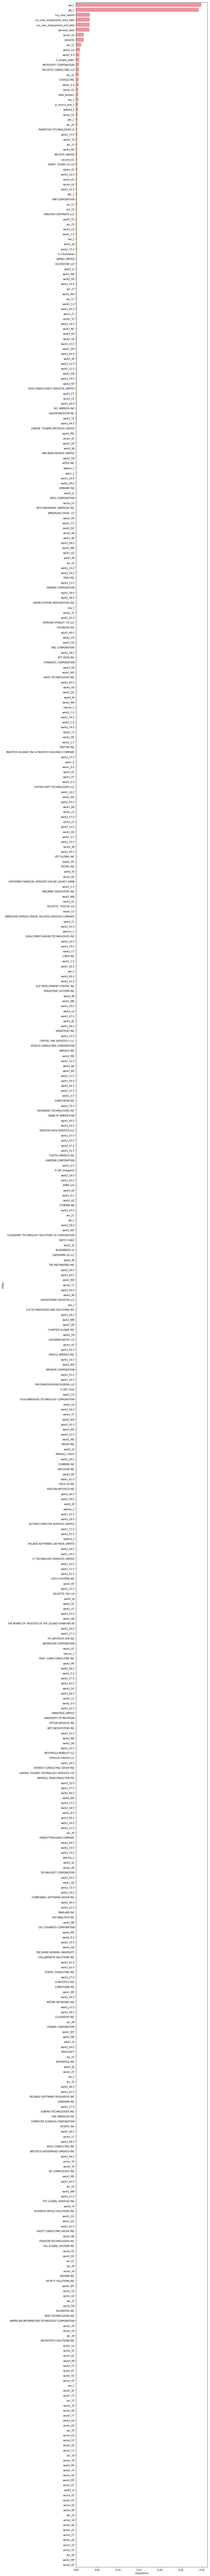

In [42]:
# check which features were important to get this score
fig = plt.figure(figsize=(10, 200))
himpdf = pd.DataFrame(rfc.feature_importances_, index=Xtrain.columns, columns=["importance"])
himpdf = himpdf.sort_values("importance", ascending=False).reset_index()
sns.barplot(x="importance", y="index", data=himpdf)

In [43]:
rfc.fit(Xtrain, lowtrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [44]:
rfc.score(Xtest, lowtest)

0.94004226573224481

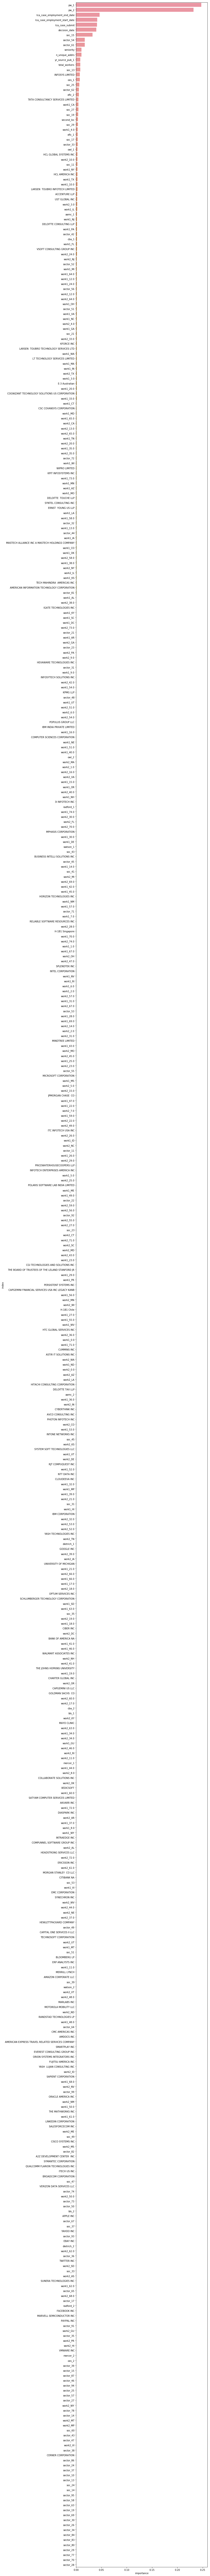

In [45]:
fig = plt.figure(figsize=(10, 200))
limpdf = pd.DataFrame(rfc.feature_importances_, index=Xtrain.columns, columns=["importance"])
limpdf = limpdf.sort_values("importance", ascending=False).reset_index()
sns.barplot(x="importance", y="index", data=limpdf)

It's good to see that the features the random forest found to have most predictive power are the same ones that the lasso regression found.

In [52]:
# let's see if tweaking helps the score any
rfc = RFC(max_features=None)
rfc.fit(Xtrain, hightrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [53]:
# longer training for no gain
rfc.score(Xtest, hightest)

0.94193880499963878

In [56]:
rfc = RFC(max_features=20, n_estimators=80)
rfc.fit(Xtrain, hightrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=20, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [57]:
rfc.score(Xtest, hightest)

0.94514485947547144

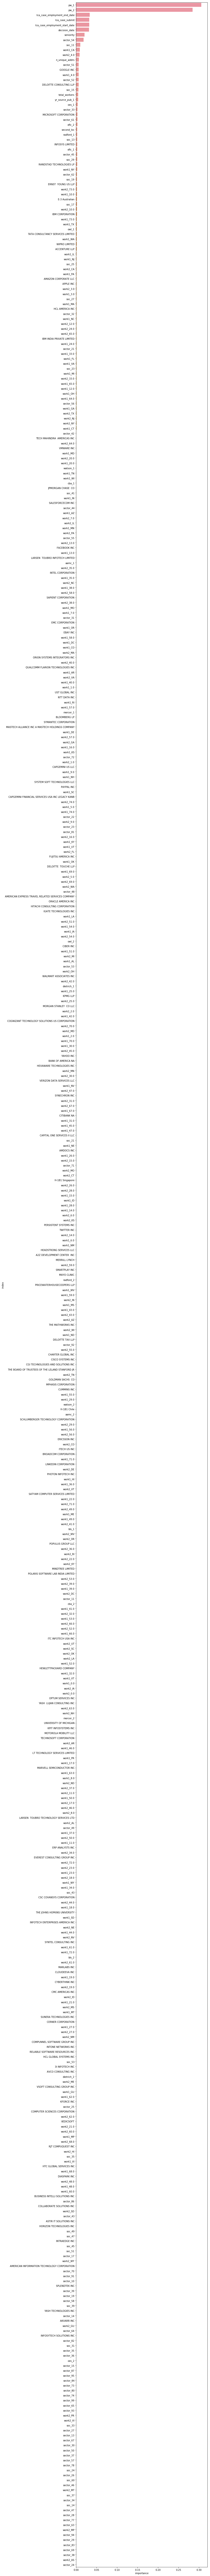

In [58]:
fig = plt.figure(figsize=(10, 200))
impdf = pd.DataFrame(rfc.feature_importances_, index=Xtrain.columns, columns=["importance"])
impdf = impdf.sort_values("importance", ascending=False).reset_index()
sns.barplot(x="importance", y="index", data=impdf)

Tweaking brought marginal gain and didn't change the important features. It seems that 95% is a difficult barrier to cross. I don't expect it's possible to get anything too close to 100%, since the boundary between high earner and others, or low earner and others, is completely arbitrary. There are no clusters of different earners, it is a clearly unimodel distribution, as seen in the data exploration.

I made a few more attempts which other models, all of which can be seen in the *Task 2 - first attempts _B*  notebook. Now I'll showcase a couple of the methods I tried in order to see if any improvements or other insights could be made. Here I'll train three different ensemble methods and build a voting classifier with them to predict earning bracket from the data:

#### Voting Classifier

In [59]:
# First for high earners

# here's an adaboost classifier
ada = AdaBoostClassifier()
ada.fit(Xtrain, hightrain)

# and another using scikit-learn's gradient boosting
gbc = GradientBoostingClassifier()
gbc.fit(Xtrain, hightrain)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [61]:
# now to combine them all
highvotes = VotingClassifier(estimators=[("rf", rfc), ("ada", ada), ("gbc", gbc)], voting="soft")

In [62]:
highvotes.fit(Xtrain, hightrain)

VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=20, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [63]:
highvotes.score(Xtest, hightest)

0.94220973918069506

The score is no better than the individual learners or other methods. This turns out to be because the learners are all highly correlated and have been trained on the very same features as each other. I don't know if it's possible to get them to train on different features as they probably cannot be calibrated to score well without using the same set of features.

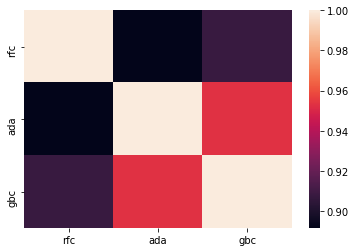

In [64]:
preddf = pd.DataFrame()
preddf["rfc"] = rfc.predict(Xtest)
preddf["ada"] = ada.predict(Xtest)
preddf["gbc"] = gbc.predict(Xtest)

predcorr = preddf.corr()
sns.heatmap(predcorr)

In [65]:
# And just for completeness, the low earners
rfc = RFC()
rfc.fit(Xtrain, lowtrain)

ada = AdaBoostClassifier()
ada.fit(Xtrain, lowtrain)

gbc = GradientBoostingClassifier()
gbc.fit(Xtrain, lowtrain)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [66]:
lowvotes = VotingClassifier(estimators=[("rf", rfc), ("ada", ada), ("gbc", gbc)], voting="soft")
lowvotes.fit(Xtrain, lowtrain)

VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_we...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [67]:
lowvotes.score(Xtest, lowtest)

0.94090925511162493

Same story again. It seems the 95% threshold stands strong.

#### Supervised Principal Components

In reading up on dealing with classification in very high-dimensional datasets like this I came across a method called Supervised Principal Components (Bair et al. 2006). This is intended for problems where the number of parameters are greater than the number of dimensions p > N. However, I thought it might be suitable in trying to get higher accuracy in this problem. It takes the the feature space and finds the principal components but does so in a way not to find the transformed dimensions which have the highest variance but to find a linear transformation which returns components that have the greatest predictive power. It works by first performing regressions on the features and using only those features which have coefficients above a certain threshold. These features are then reduced using PCA and the resulting components used in a regression

I found one python implementation of the model online but it didn't work as expected so, rather than trust it, I made a simple implementation using a scikit-learn pipeline, just to see what kind of performance it might have in this situation. I used the SelectKBest function to pick out the best features, rather than selecting by threshold.

In [68]:
myspc = pipeline.make_pipeline(feature_selection.SelectKBest(k=50),
                               decomposition.PCA(copy=True),
                               LogisticRegression(penalty='l1', C=0.02, solver='saga'))

In [69]:
myspc.fit(Xtrain, hightrain)

/home/kilian/virtualenvs/elucd/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [150] are constant.
  UserWarning)
/home/kilian/virtualenvs/elucd/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Pipeline(memory=None,
     steps=[('selectkbest', SelectKBest(k=50, score_func=<function f_classif at 0x7fd413f51268>)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logisticregression', LogisticRegression(C=0.02, class_weight=None, dual=Fa...penalty='l1', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False))])

In [70]:
myspc.score(Xtest, hightest)

0.92537569539773135

In [71]:
myspc.fit(Xtrain, lowtrain)

/home/kilian/virtualenvs/elucd/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [150] are constant.
  UserWarning)
/home/kilian/virtualenvs/elucd/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Pipeline(memory=None,
     steps=[('selectkbest', SelectKBest(k=50, score_func=<function f_classif at 0x7fd413f51268>)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logisticregression', LogisticRegression(C=0.02, class_weight=None, dual=Fa...penalty='l1', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False))])

In [72]:
myspc.score(Xtest, lowtest)

0.91016725670110543

For the SelectKBest function, I just use the default scoring function, which is meant for classification and uses an ANOVA F values, but I could possibly improve on this by passing a tuned regressor:

In [75]:
def lasso_score(X, y):
    lasso = SGDClassifier(loss='log', penalty='l1', alpha=0.0001, tol=0.001, max_iter=80)
    lasso.fit(X, y)
    
    # just return coefficients, as they approximate explained variance for standardised variables
    return lasso.coef_.flatten()

myspc = pipeline.make_pipeline(feature_selection.SelectKBest(score_func=lasso_score, k=50),
                               decomposition.PCA(copy=True),
                               LogisticRegression(penalty='l1', C=0.02, solver='saga'))

In [76]:
myspc.fit(Xtrain, hightrain)

Pipeline(memory=None,
     steps=[('selectkbest', SelectKBest(k=50, score_func=<function lasso_score at 0x7fd3460d0e18>)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logisticregression', LogisticRegression(C=0.02, class_weight=None, dual=...penalty='l1', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False))])

In [77]:
myspc.score(Xtest, hightest)

0.92857271873419556

In [78]:
myspc.fit(Xtrain, lowtrain)

Pipeline(memory=None,
     steps=[('selectkbest', SelectKBest(k=50, score_func=<function lasso_score at 0x7fd3460d0e18>)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logisticregression', LogisticRegression(C=0.02, class_weight=None, dual=...penalty='l1', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False))])

In [79]:
myspc.score(Xtest, lowtest)

0.83756592731739032

So it manages to get comparably good results but suffers from the problem that it is less interpretable due to the transformations in the PCA. The fact that there is no real gain on the accuracy of the lasso suggests that the PCA transformation does not necessarily expose better dimensions to work in, but this would require more investigation to figure out. There may be other ways of improving the accuracy, such as maybe implementing an iterative version of the procedure (like the one developed here: https://arxiv.org/pdf/1710.06229.pdf) but I am still skeptical that it would beat the ensemble learners given the nature of the arbitrary use of 25 and 75 percentile cutoffs for the classes.